In [ ]:
import jax.numpy as jnp
from fbpinns.problems import Problem

class Poisson2D(Problem):
    """
    Solves the 2D Poisson equation
        - (u_xx + u_yy) = f(x,y)
    on the domain [0,1] x [0,1] with Dirichlet boundary conditions u = 0 on ∂Ω.

    We choose f(x,y) such that the exact solution is:
        u(x,y) = sin(πx) sin(πy),
    which implies f(x,y) = 2π² sin(πx) sin(πy).
    """

    @staticmethod
    def init_params(f_coeff=2 * (jnp.pi ** 2), sd=0.1):
        # 'dims': (ud, xd) => u is scalar (ud=1) and x is 2D (xd=2)
        static_params = {
            "dims": (1, 2),
            "f_coeff": f_coeff,  # coefficient in the forcing function f(x,y)
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # --- Physics loss: sample interior points ---
        # x_batch_phys: an array of shape (n_phys, 2)
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        # We require:
        #   (0,(0,0))    -> second derivative with respect to the first coordinate (u_xx)
        #   (0,(1,1))    -> second derivative with respect to the second coordinate (u_yy)
        required_ujs_phys = (
            (0, (0, 0)),
            (0, (1, 1))
        )

        # Physics constraints: [interior points, tuple of required solution and derivative indices]
        return [[x_batch_phys, required_ujs_phys],]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, y, tanh = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh
        # u = tanh((0-x)/sd) * tanh((1-x)/sd) * tanh((0-y)/sd) * tanh((1-y)/sd) * u
        b, c = -1, 1
        u = tanh((b-x)/sd) * tanh((c-x)/sd) * tanh((b-y)/sd) * tanh((c-y)/sd) * u
        # u = 1/sd * x * (1-x)* y *(1-y) * u
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        # --- Physics loss ---
        # For the physics group, the constraints have been replaced with the evaluated quantities:
        # [x_batch_phys, u_xx, u_yy]
        x_phys, u_xx, u_yy = constraints[0]
        x = x_phys[:, 0:1]
        y = x_phys[:, 1:2]

        # Compute the forcing term f(x,y) = 2π² sin(πx) sin(πy)
        f_coeff = all_params["static"]["problem"]["f_coeff"]
        f_val = (jnp.pi ** 2)/2 * jnp.cos(jnp.pi/2 * x) * jnp.cos(jnp.pi/2 * y)

        # The physics residual is: u_xx + u_yy + f(x,y)
        phys_residual = u_xx + u_yy + f_val

        return jnp.mean(phys_residual ** 2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        # The exact solution is u(x,y) = sin(πx) sin(πy)
        x = x_batch[:, 0:1]
        y = x_batch[:, 1:2]
        u = jnp.cos(jnp.pi/2 * x) * jnp.cos(jnp.pi/2 * y)
        return u
    

[INFO] 2025-03-26 19:46:23 - <fbpinns.constants.Constants object at 0x72a86556f9b0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-1., -1.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.Poisson2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]), array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ])], 'subdoma

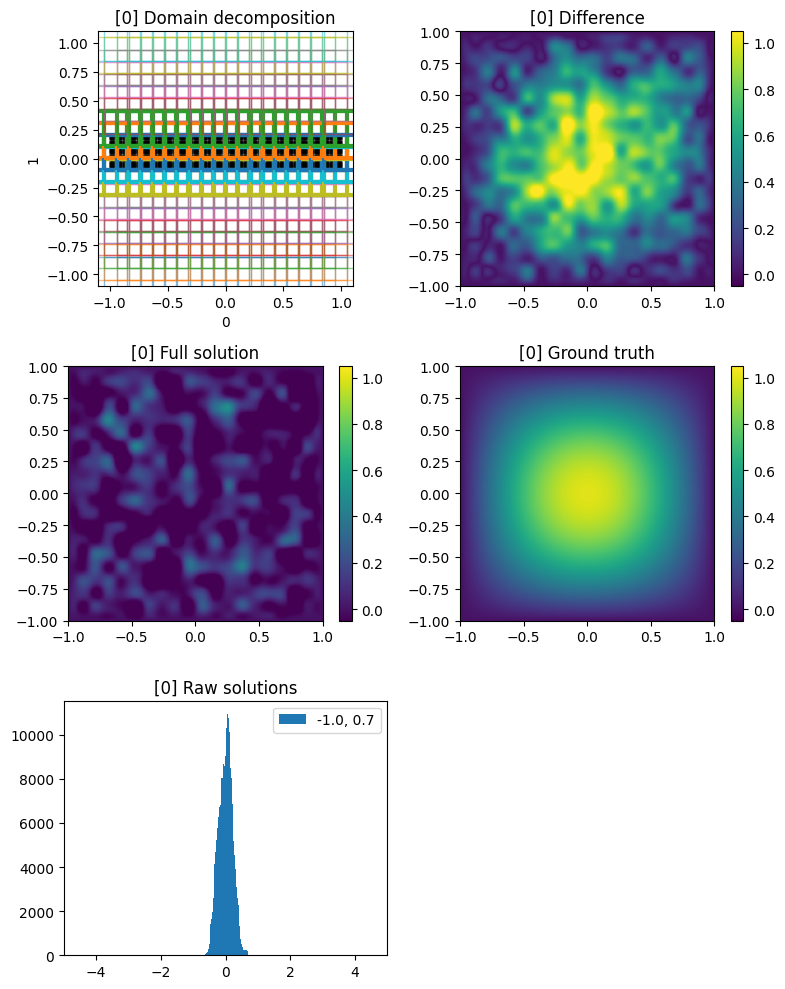

[INFO] 2025-03-26 19:46:36 - saved arrays
[INFO] 2025-03-26 19:46:36 - [i: 1/100000] Updating active inputs..
[INFO] 2025-03-26 19:46:36 - [i: 1/100000] Average number of points/dimension in active subdomains: 29.24
[INFO] 2025-03-26 19:46:39 - [i: 1/100000] Updating active inputs done (3.02 s)
[INFO] 2025-03-26 19:46:39 - [i: 1/100000] Compiling update step..
[INFO] 2025-03-26 19:46:39 - x_batch
[INFO] 2025-03-26 19:46:39 - (8000, 2), float32, JVPTracer
[INFO] 2025-03-26 19:46:39 - x_take
[INFO] 2025-03-26 19:46:39 - (66120, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:46:39 - x_batch
[INFO] 2025-03-26 19:46:39 - (8000, 2), float32, JVPTracer
[INFO] 2025-03-26 19:46:39 - x_take
[INFO] 2025-03-26 19:46:39 - (66120, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:46:41 - [i: 1/100000] Compiling done (1.70 s)
[INFO] 2025-03-26 19:46:42 - [i: 1000/100000] loss: 0.6549 rate: 92.4 elapsed: 0.00 hr test
[INFO] 2

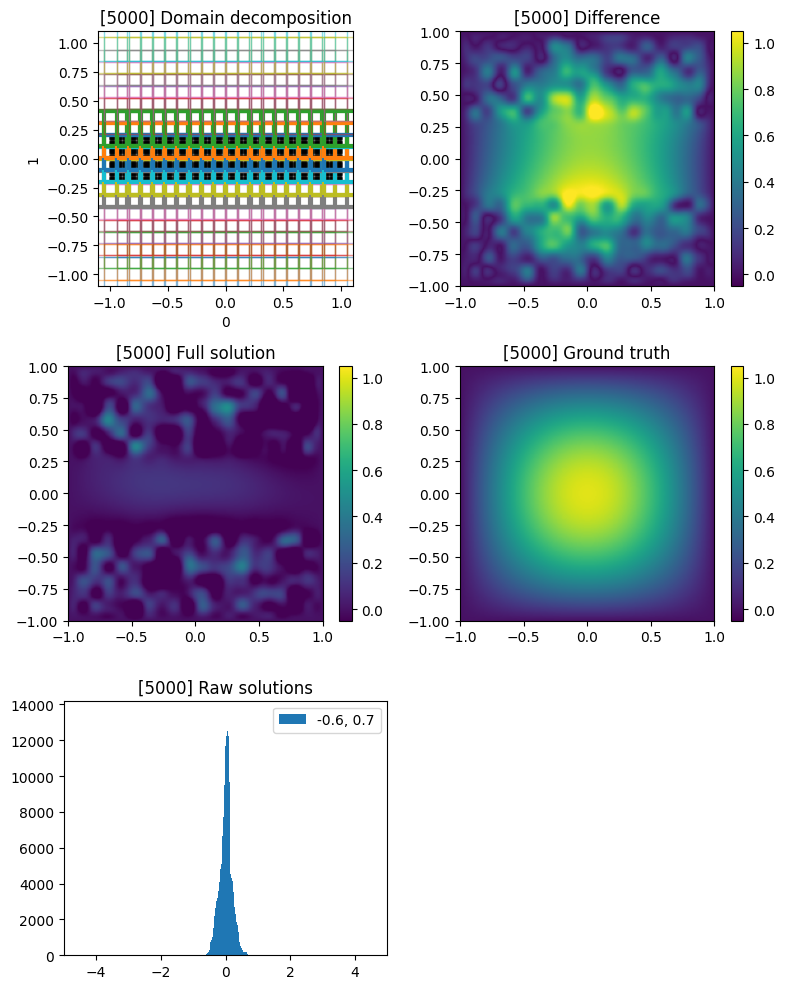

[INFO] 2025-03-26 19:46:49 - saved arrays
[INFO] 2025-03-26 19:46:50 - [i: 6000/100000] loss: 0.0084 rate: 742.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:46:51 - [i: 7000/100000] loss: 0.0214 rate: 750.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:46:53 - [i: 8000/100000] loss: 0.0205 rate: 755.4 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:46:54 - [i: 9000/100000] loss: 0.0037 rate: 755.0 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:46:56 - [i: 10000/100000] loss: 0.3589 rate: 755.2 elapsed: 0.01 hr test
True


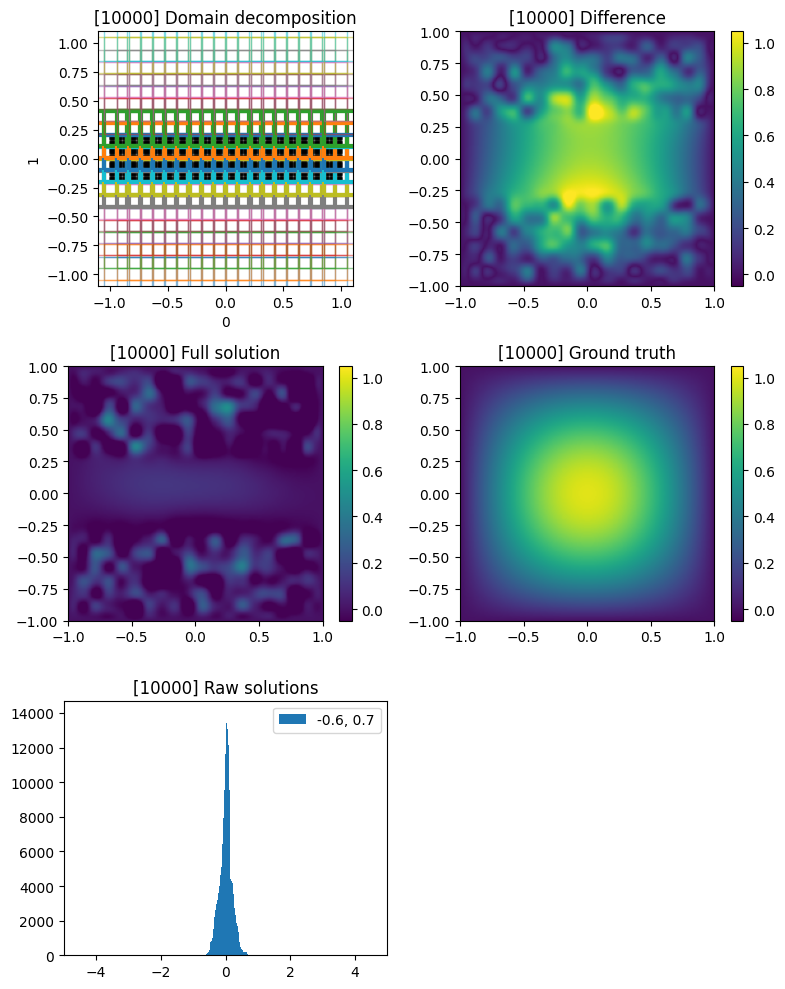

[INFO] 2025-03-26 19:46:57 - saved arrays
[INFO] 2025-03-26 19:46:57 - [i: 10000/100000] Updating active inputs..
[INFO] 2025-03-26 19:46:57 - [i: 10000/100000] Average number of points/dimension in active subdomains: 29.24
[INFO] 2025-03-26 19:46:59 - [i: 10000/100000] Updating active inputs done (2.76 s)
[INFO] 2025-03-26 19:46:59 - [i: 10000/100000] Compiling update step..
[INFO] 2025-03-26 19:46:59 - x_batch
[INFO] 2025-03-26 19:46:59 - (10200, 2), float32, JVPTracer
[INFO] 2025-03-26 19:46:59 - x_take
[INFO] 2025-03-26 19:46:59 - (84360, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:47:00 - x_batch
[INFO] 2025-03-26 19:47:00 - (10200, 2), float32, JVPTracer
[INFO] 2025-03-26 19:47:00 - x_take
[INFO] 2025-03-26 19:47:00 - (84360, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:47:01 - [i: 10000/100000] Compiling done (1.73 s)
[INFO] 2025-03-26 19:47:01 - [i: 10001/100000] Updating active inputs..
[INFO]

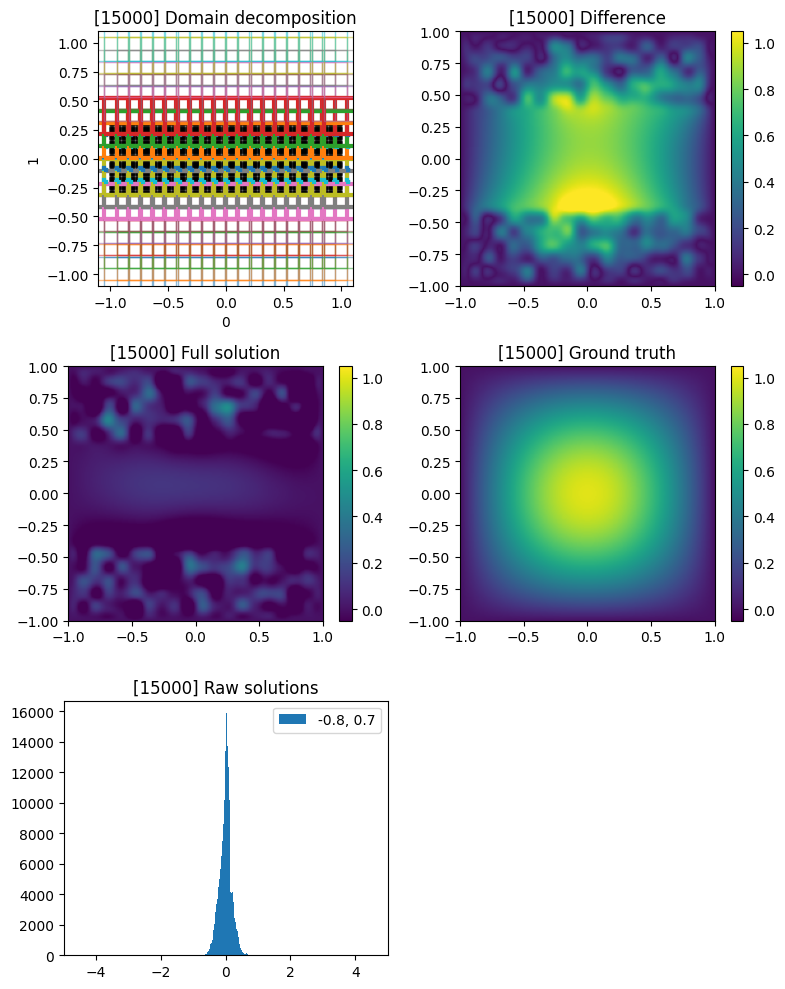

[INFO] 2025-03-26 19:47:16 - saved arrays
[INFO] 2025-03-26 19:47:17 - [i: 16000/100000] loss: 0.0966 rate: 596.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:47:19 - [i: 17000/100000] loss: 0.0523 rate: 591.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:47:21 - [i: 18000/100000] loss: 0.0534 rate: 592.0 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:47:23 - [i: 19000/100000] loss: 0.2185 rate: 592.0 elapsed: 0.01 hr test
[INFO] 2025-03-26 19:47:24 - [i: 20000/100000] loss: 0.0486 rate: 590.7 elapsed: 0.02 hr test
True


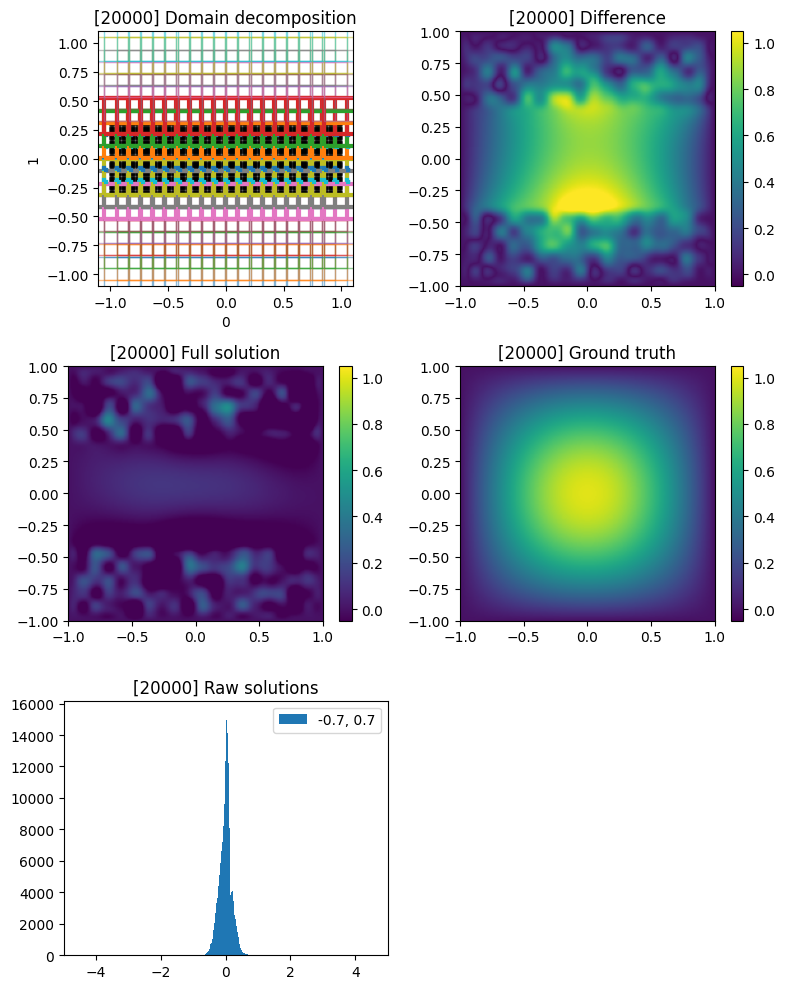

[INFO] 2025-03-26 19:47:25 - saved arrays
[INFO] 2025-03-26 19:47:25 - [i: 20000/100000] Updating active inputs..
[INFO] 2025-03-26 19:47:25 - [i: 20000/100000] Average number of points/dimension in active subdomains: 29.24
[INFO] 2025-03-26 19:47:26 - [i: 20000/100000] Updating active inputs done (0.91 s)
[INFO] 2025-03-26 19:47:26 - [i: 20000/100000] Compiling update step..
[INFO] 2025-03-26 19:47:26 - x_batch
[INFO] 2025-03-26 19:47:26 - (12000, 2), float32, JVPTracer
[INFO] 2025-03-26 19:47:26 - x_take
[INFO] 2025-03-26 19:47:26 - (100320, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:47:26 - x_batch
[INFO] 2025-03-26 19:47:26 - (12000, 2), float32, JVPTracer
[INFO] 2025-03-26 19:47:26 - x_take
[INFO] 2025-03-26 19:47:26 - (100320, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:47:28 - [i: 20000/100000] Compiling done (1.75 s)
[INFO] 2025-03-26 19:47:30 - [i: 21000/100000] loss: 0.1349 rate: 228.5 elap

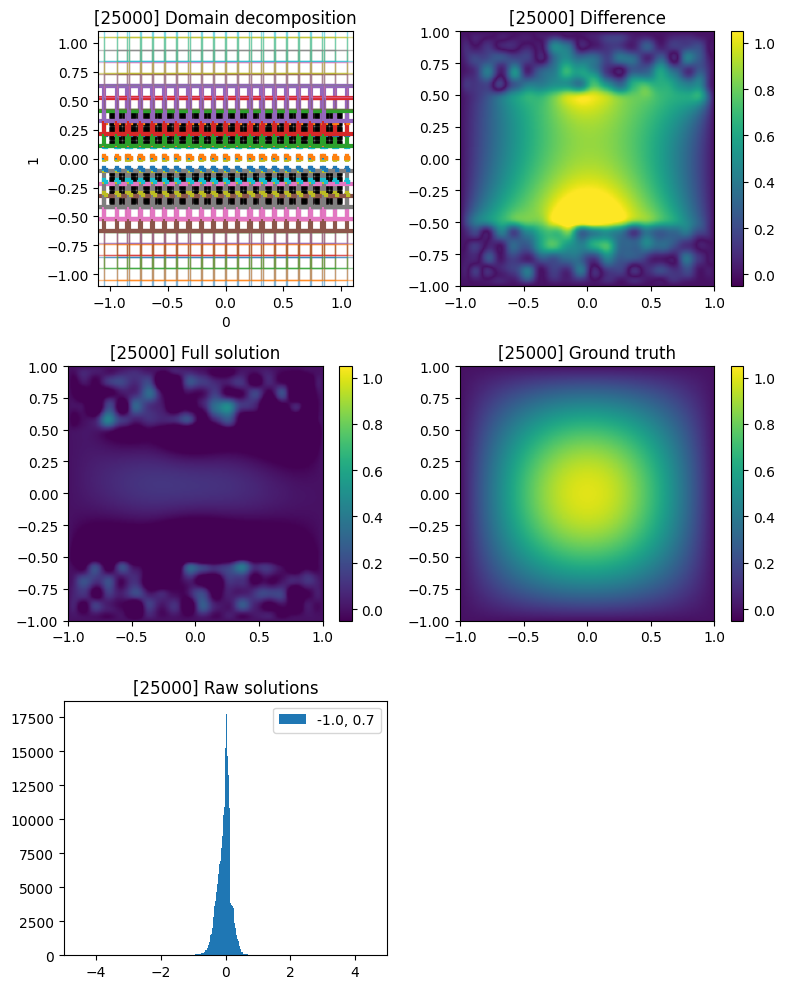

[INFO] 2025-03-26 19:47:38 - saved arrays
[INFO] 2025-03-26 19:47:39 - [i: 26000/100000] loss: 0.0149 rate: 596.6 elapsed: 0.02 hr test
[INFO] 2025-03-26 19:47:41 - [i: 27000/100000] loss: 0.0154 rate: 600.5 elapsed: 0.02 hr test
[INFO] 2025-03-26 19:47:43 - [i: 28000/100000] loss: 0.0124 rate: 593.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 19:47:45 - [i: 29000/100000] loss: 0.0107 rate: 597.2 elapsed: 0.02 hr test
[INFO] 2025-03-26 19:47:46 - [i: 30000/100000] loss: 0.0098 rate: 594.4 elapsed: 0.02 hr test
True


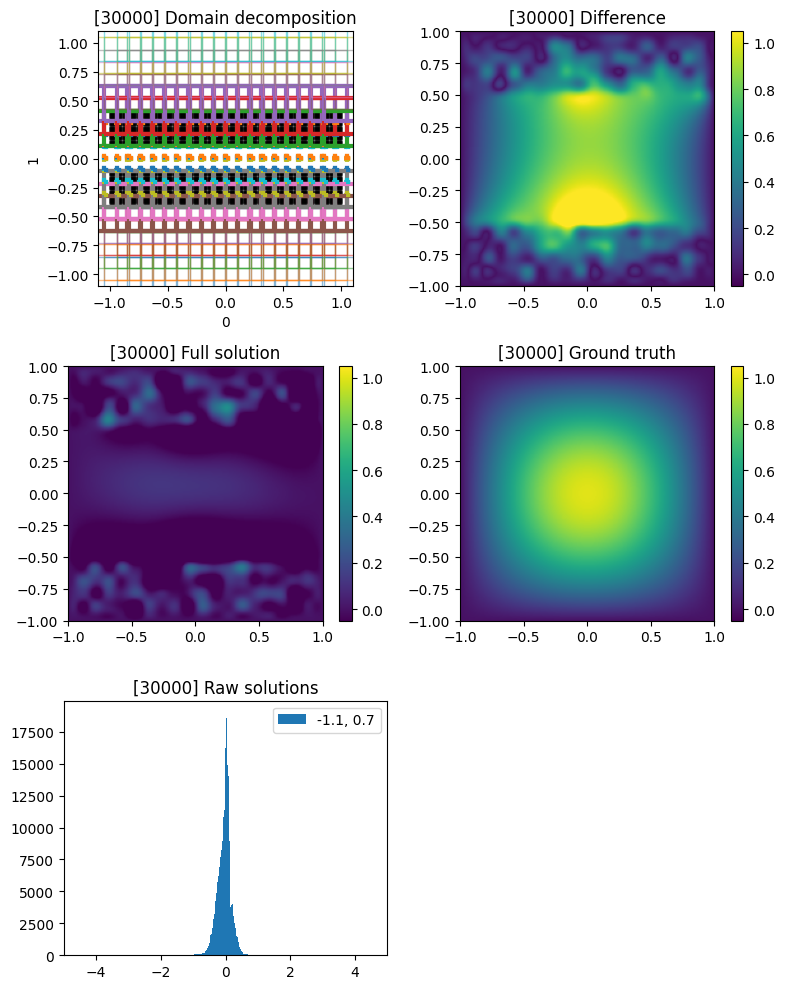

[INFO] 2025-03-26 19:47:47 - saved arrays
[INFO] 2025-03-26 19:47:47 - [i: 30000/100000] Updating active inputs..
[INFO] 2025-03-26 19:47:48 - [i: 30000/100000] Average number of points/dimension in active subdomains: 29.72


E0326 19:47:49.733630 3940342 hlo_lexer.cc:443] Failed to parse int literal: 8135538351173349231619


[INFO] 2025-03-26 19:47:50 - [i: 30000/100000] Updating active inputs done (2.20 s)
[INFO] 2025-03-26 19:47:50 - [i: 30000/100000] Compiling update step..
[INFO] 2025-03-26 19:47:50 - x_batch
[INFO] 2025-03-26 19:47:50 - (12400, 2), float32, JVPTracer
[INFO] 2025-03-26 19:47:50 - x_take
[INFO] 2025-03-26 19:47:50 - (103740, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:47:50 - x_batch
[INFO] 2025-03-26 19:47:50 - (12400, 2), float32, JVPTracer
[INFO] 2025-03-26 19:47:50 - x_take
[INFO] 2025-03-26 19:47:50 - (103740, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:47:51 - [i: 30000/100000] Compiling done (1.85 s)
[INFO] 2025-03-26 19:47:53 - [i: 31000/100000] loss: 0.9161 rate: 170.8 elapsed: 0.02 hr test
[INFO] 2025-03-26 19:47:55 - [i: 32000/100000] loss: 0.3342 rate: 560.1 elapsed: 0.02 hr test
[INFO] 2025-03-26 19:47:57 - [i: 33000/100000] loss: 0.1694 rate: 564.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 

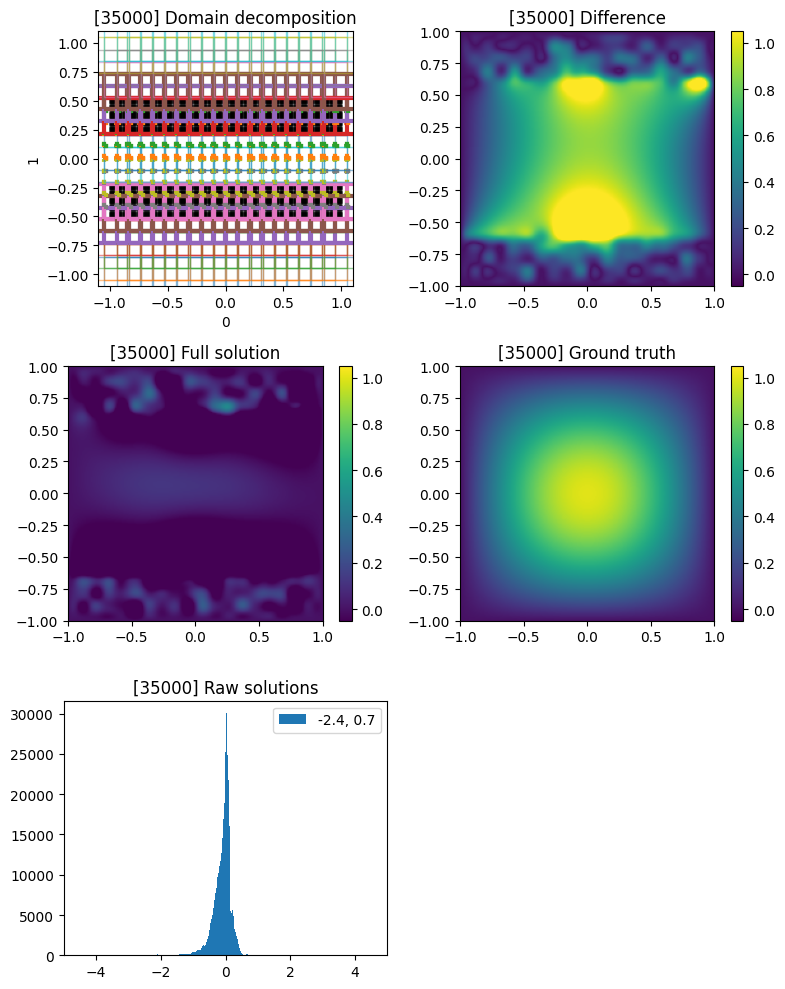

[INFO] 2025-03-26 19:48:01 - saved arrays
[INFO] 2025-03-26 19:48:03 - [i: 36000/100000] loss: 0.0583 rate: 571.6 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:05 - [i: 37000/100000] loss: 0.0650 rate: 564.2 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:07 - [i: 38000/100000] loss: 0.0422 rate: 565.9 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:09 - [i: 39000/100000] loss: 0.0348 rate: 565.4 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:11 - [i: 40000/100000] loss: 0.0839 rate: 561.4 elapsed: 0.03 hr test
True


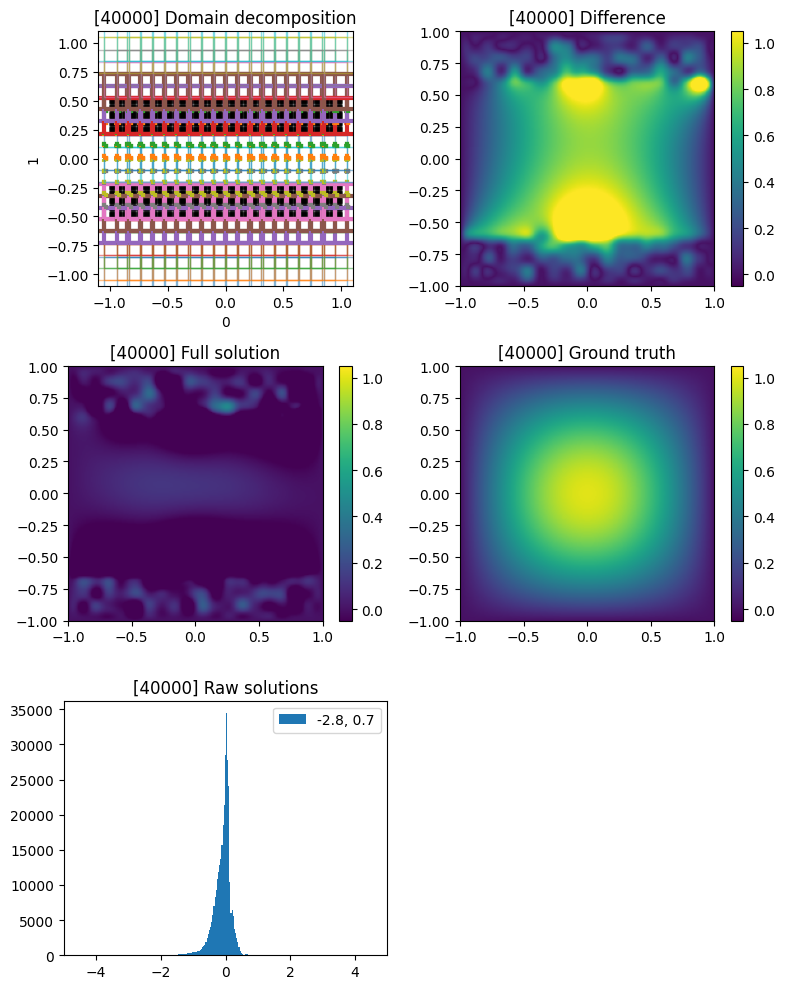

[INFO] 2025-03-26 19:48:11 - saved arrays
[INFO] 2025-03-26 19:48:12 - [i: 40000/100000] Updating active inputs..
[INFO] 2025-03-26 19:48:12 - [i: 40000/100000] Average number of points/dimension in active subdomains: 29.24
[INFO] 2025-03-26 19:48:12 - [i: 40000/100000] Updating active inputs done (0.05 s)
[INFO] 2025-03-26 19:48:12 - [i: 40000/100000] Compiling update step..
[INFO] 2025-03-26 19:48:12 - [i: 40000/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 19:48:13 - [i: 41000/100000] loss: 5.4618 rate: 558.9 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:15 - [i: 42000/100000] loss: 2.5996 rate: 591.7 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:17 - [i: 43000/100000] loss: 1.6111 rate: 600.1 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:19 - [i: 44000/100000] loss: 1.0370 rate: 602.0 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:20 - [i: 45000/100000] loss: 0.6585 rate: 605.8 elapsed: 0.03 hr test
True


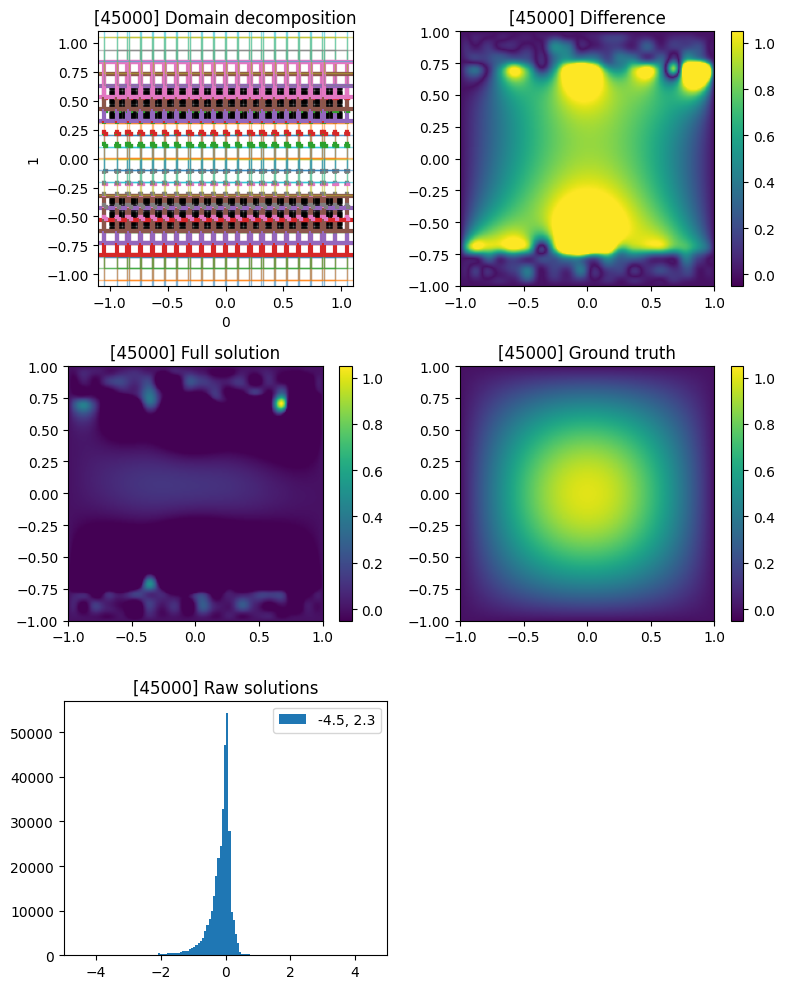

[INFO] 2025-03-26 19:48:21 - saved arrays
[INFO] 2025-03-26 19:48:23 - [i: 46000/100000] loss: 0.4359 rate: 598.4 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:25 - [i: 47000/100000] loss: 0.2792 rate: 602.4 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:27 - [i: 48000/100000] loss: 0.6485 rate: 600.1 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:28 - [i: 49000/100000] loss: 0.1924 rate: 597.0 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:30 - [i: 50000/100000] loss: 0.1714 rate: 602.1 elapsed: 0.03 hr test
True


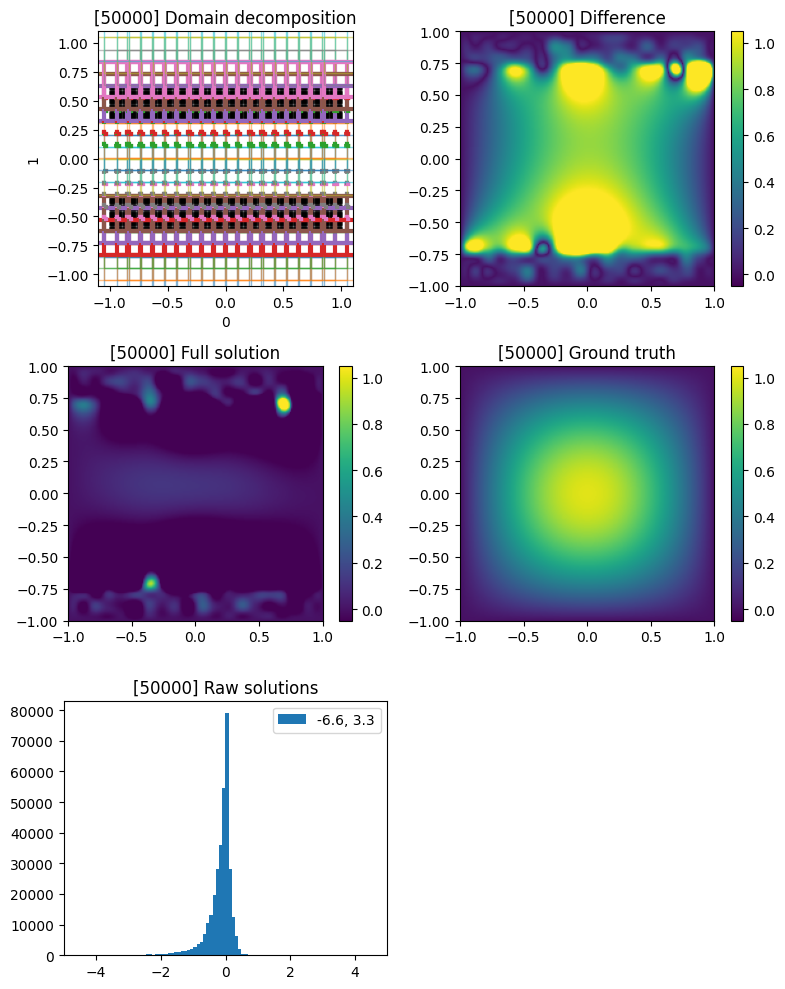

[INFO] 2025-03-26 19:48:31 - saved arrays
[INFO] 2025-03-26 19:48:31 - [i: 50000/100000] Updating active inputs..
[INFO] 2025-03-26 19:48:31 - [i: 50000/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 19:48:31 - [i: 50000/100000] Updating active inputs done (0.05 s)
[INFO] 2025-03-26 19:48:31 - [i: 50000/100000] Compiling update step..
[INFO] 2025-03-26 19:48:31 - [i: 50000/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 19:48:33 - [i: 51000/100000] loss: 67.7286 rate: 545.3 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:35 - [i: 52000/100000] loss: 42.8664 rate: 574.3 elapsed: 0.03 hr test
[INFO] 2025-03-26 19:48:36 - [i: 53000/100000] loss: 29.5252 rate: 569.1 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:38 - [i: 54000/100000] loss: 19.4192 rate: 566.6 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:40 - [i: 55000/100000] loss: 13.1658 rate: 569.4 elapsed: 0.04 hr test
True


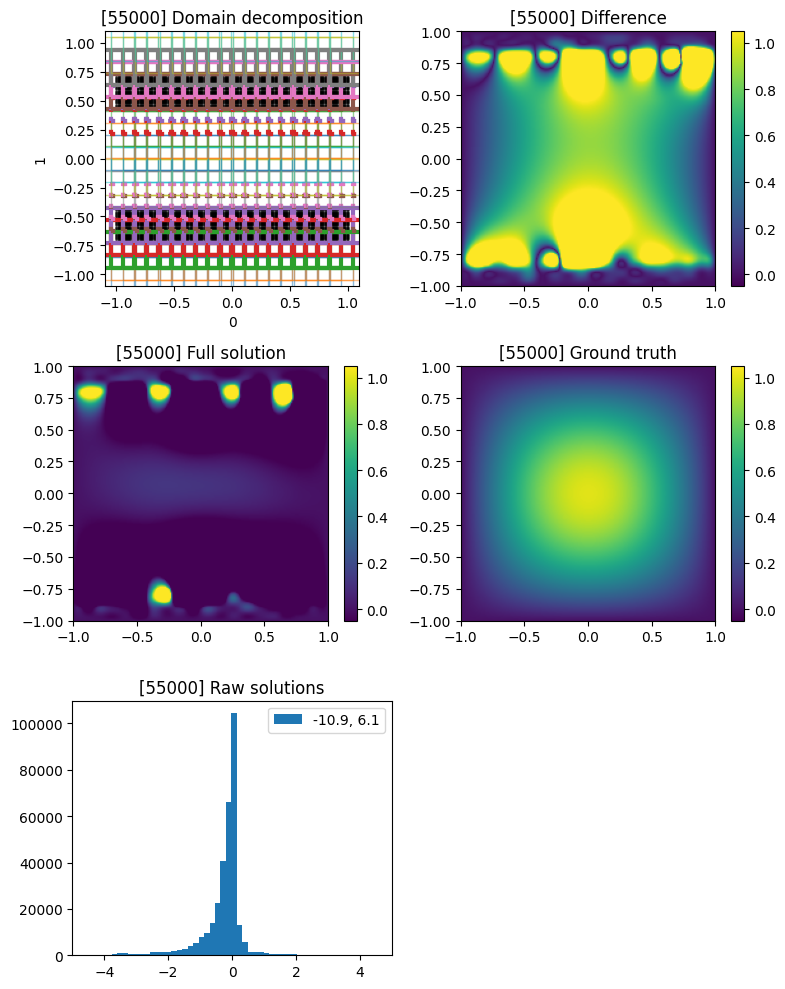

[INFO] 2025-03-26 19:48:41 - saved arrays
[INFO] 2025-03-26 19:48:43 - [i: 56000/100000] loss: 8.1566 rate: 573.5 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:45 - [i: 57000/100000] loss: 5.3523 rate: 570.0 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:46 - [i: 58000/100000] loss: 3.8008 rate: 568.2 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:48 - [i: 59000/100000] loss: 2.9258 rate: 569.9 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:50 - [i: 60000/100000] loss: 1.9742 rate: 567.2 elapsed: 0.04 hr test
True


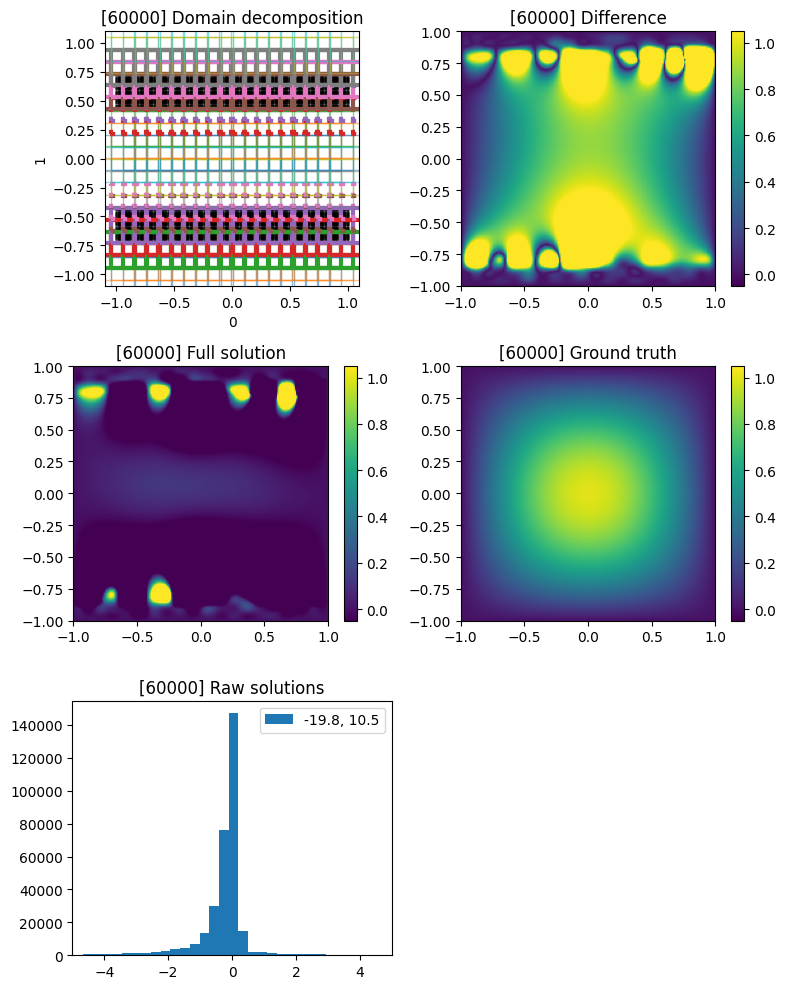

[INFO] 2025-03-26 19:48:51 - saved arrays
[INFO] 2025-03-26 19:48:51 - [i: 60000/100000] Updating active inputs..
[INFO] 2025-03-26 19:48:51 - [i: 60000/100000] Average number of points/dimension in active subdomains: 29.24
[INFO] 2025-03-26 19:48:51 - [i: 60000/100000] Updating active inputs done (0.05 s)
[INFO] 2025-03-26 19:48:51 - [i: 60000/100000] Compiling update step..
[INFO] 2025-03-26 19:48:51 - [i: 60000/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 19:48:53 - [i: 61000/100000] loss: 1320.4500 rate: 563.4 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:54 - [i: 62000/100000] loss: 930.5067 rate: 589.0 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:56 - [i: 63000/100000] loss: 522.1301 rate: 595.7 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:48:58 - [i: 64000/100000] loss: 281.3449 rate: 593.1 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:49:00 - [i: 65000/100000] loss: 159.8417 rate: 590.1 elapsed: 0.04 hr test
True


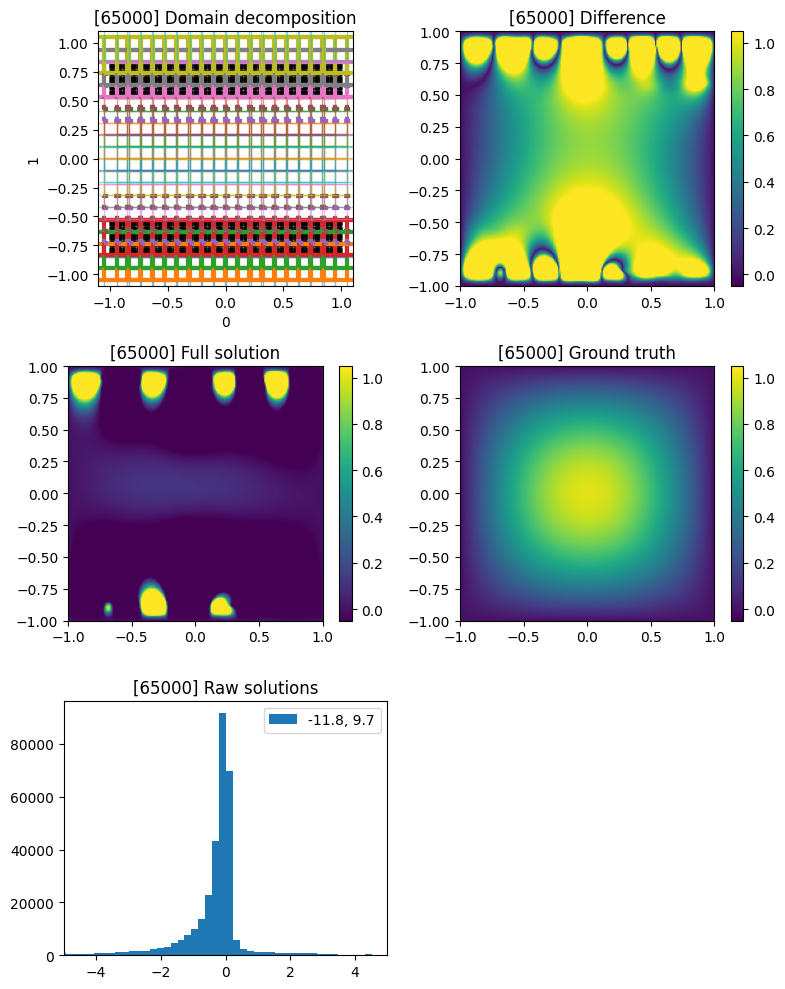

[INFO] 2025-03-26 19:49:01 - saved arrays
[INFO] 2025-03-26 19:49:02 - [i: 66000/100000] loss: 105.2527 rate: 592.3 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:49:04 - [i: 67000/100000] loss: 74.7306 rate: 595.6 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:49:06 - [i: 68000/100000] loss: 52.5353 rate: 593.1 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:49:08 - [i: 69000/100000] loss: 36.5719 rate: 597.3 elapsed: 0.04 hr test
[INFO] 2025-03-26 19:49:09 - [i: 70000/100000] loss: 26.0076 rate: 596.0 elapsed: 0.04 hr test
True


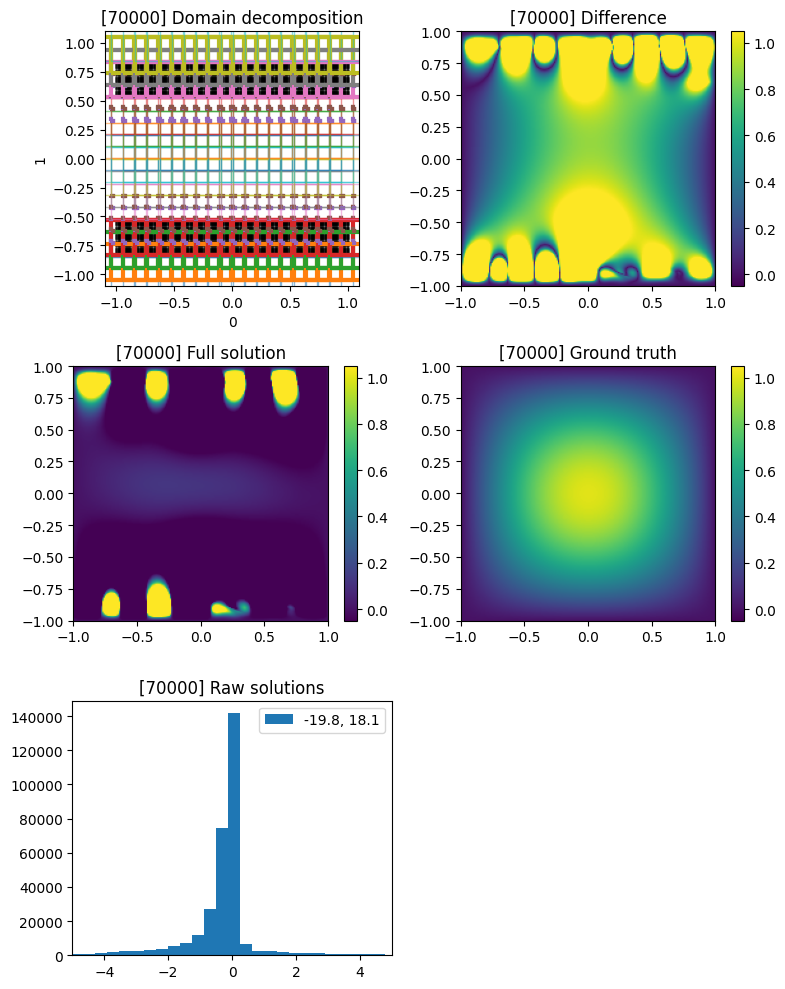

[INFO] 2025-03-26 19:49:10 - saved arrays
[INFO] 2025-03-26 19:49:10 - [i: 70000/100000] Updating active inputs..
[INFO] 2025-03-26 19:49:10 - [i: 70000/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 19:49:10 - [i: 70000/100000] Updating active inputs done (0.11 s)
[INFO] 2025-03-26 19:49:10 - [i: 70000/100000] Compiling update step..
[INFO] 2025-03-26 19:49:10 - [i: 70000/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 19:49:12 - [i: 71000/100000] loss: 7790.7700 rate: 520.1 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:14 - [i: 72000/100000] loss: 6530.2158 rate: 562.7 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:16 - [i: 73000/100000] loss: 5632.9829 rate: 567.8 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:18 - [i: 74000/100000] loss: 4834.0684 rate: 565.7 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:20 - [i: 75000/100000] loss: 3238.3936 rate: 565.8 elapsed: 0.05 hr test
True


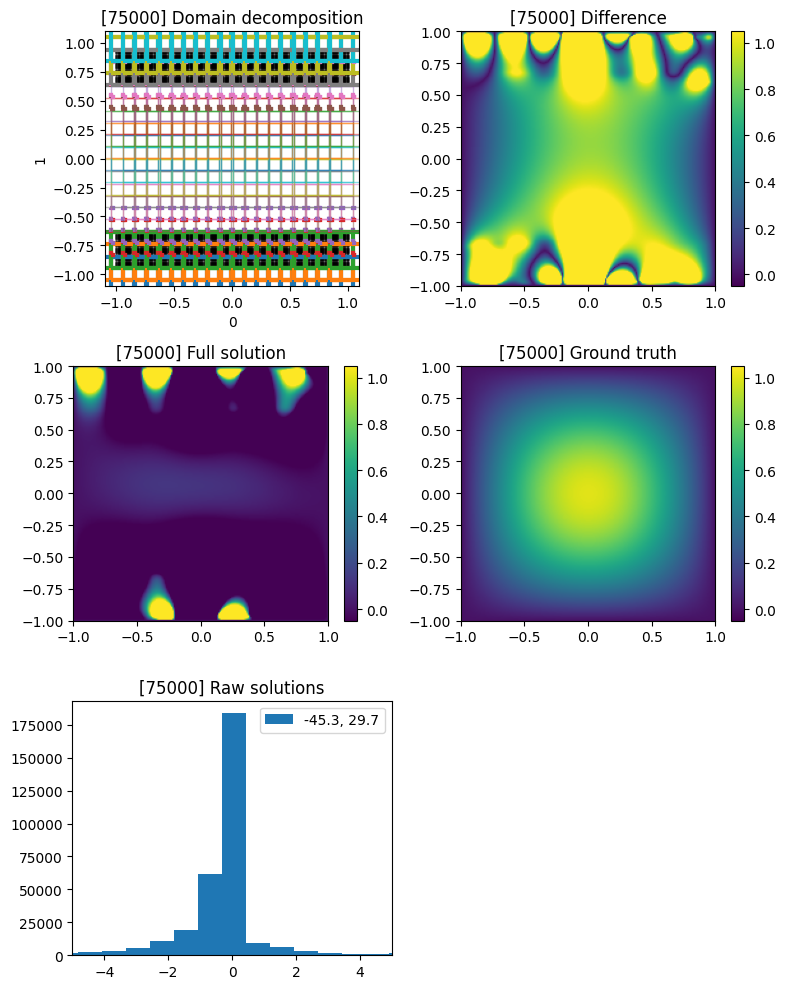

[INFO] 2025-03-26 19:49:21 - saved arrays
[INFO] 2025-03-26 19:49:22 - [i: 76000/100000] loss: 875.1663 rate: 569.1 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:24 - [i: 77000/100000] loss: 399.5941 rate: 569.5 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:26 - [i: 78000/100000] loss: 196.6628 rate: 567.3 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:28 - [i: 79000/100000] loss: 101.7903 rate: 565.5 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:30 - [i: 80000/100000] loss: 61.9342 rate: 565.0 elapsed: 0.05 hr test
True


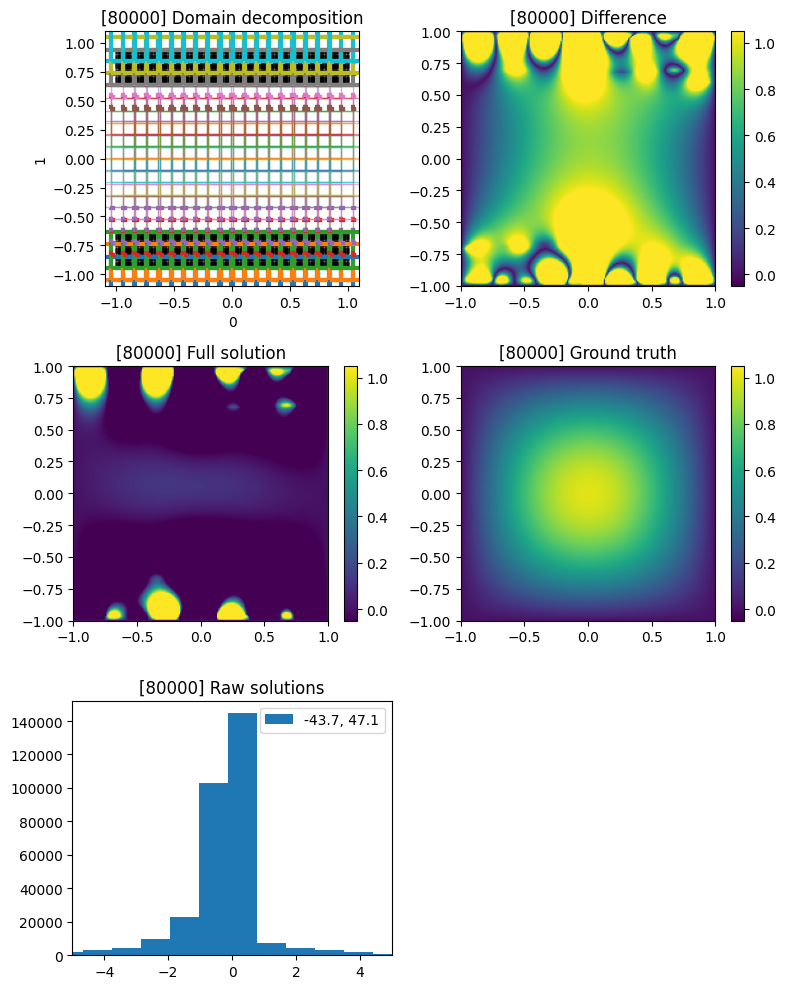

[INFO] 2025-03-26 19:49:31 - saved arrays
[INFO] 2025-03-26 19:49:31 - [i: 80000/100000] Updating active inputs..
[INFO] 2025-03-26 19:49:31 - [i: 80000/100000] Average number of points/dimension in active subdomains: 27.22
[INFO] 2025-03-26 19:49:33 - [i: 80000/100000] Updating active inputs done (2.10 s)
[INFO] 2025-03-26 19:49:33 - [i: 80000/100000] Compiling update step..
[INFO] 2025-03-26 19:49:33 - x_batch
[INFO] 2025-03-26 19:49:33 - (10400, 2), float32, JVPTracer
[INFO] 2025-03-26 19:49:33 - x_take
[INFO] 2025-03-26 19:49:33 - (80940, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:49:33 - x_batch
[INFO] 2025-03-26 19:49:33 - (10400, 2), float32, JVPTracer
[INFO] 2025-03-26 19:49:33 - x_take
[INFO] 2025-03-26 19:49:33 - (80940, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:49:35 - [i: 80000/100000] Compiling done (1.87 s)
[INFO] 2025-03-26 19:49:36 - [i: 81000/100000] loss: 28460.7930 rate: 186.3 el

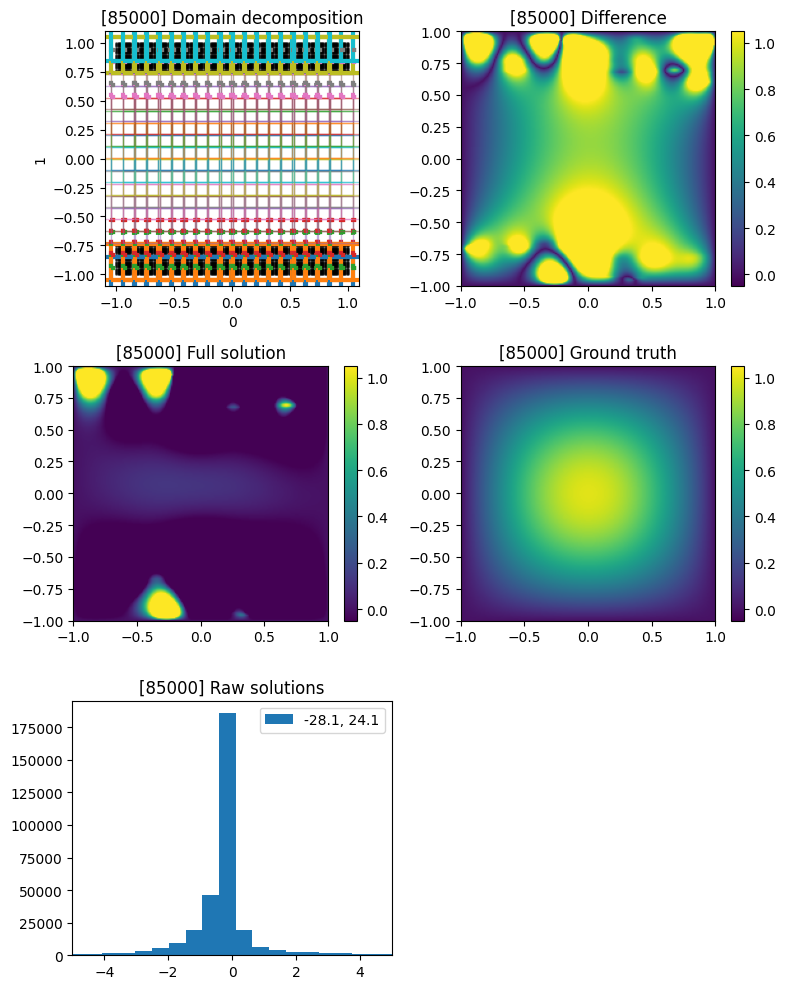

[INFO] 2025-03-26 19:49:43 - saved arrays
[INFO] 2025-03-26 19:49:44 - [i: 86000/100000] loss: 2919.9407 rate: 740.2 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:46 - [i: 87000/100000] loss: 1421.0763 rate: 736.5 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:47 - [i: 88000/100000] loss: 768.1957 rate: 735.2 elapsed: 0.05 hr test
[INFO] 2025-03-26 19:49:48 - [i: 89000/100000] loss: 458.2686 rate: 731.5 elapsed: 0.06 hr test
[INFO] 2025-03-26 19:49:50 - [i: 90000/100000] loss: 275.1499 rate: 726.2 elapsed: 0.06 hr test
True


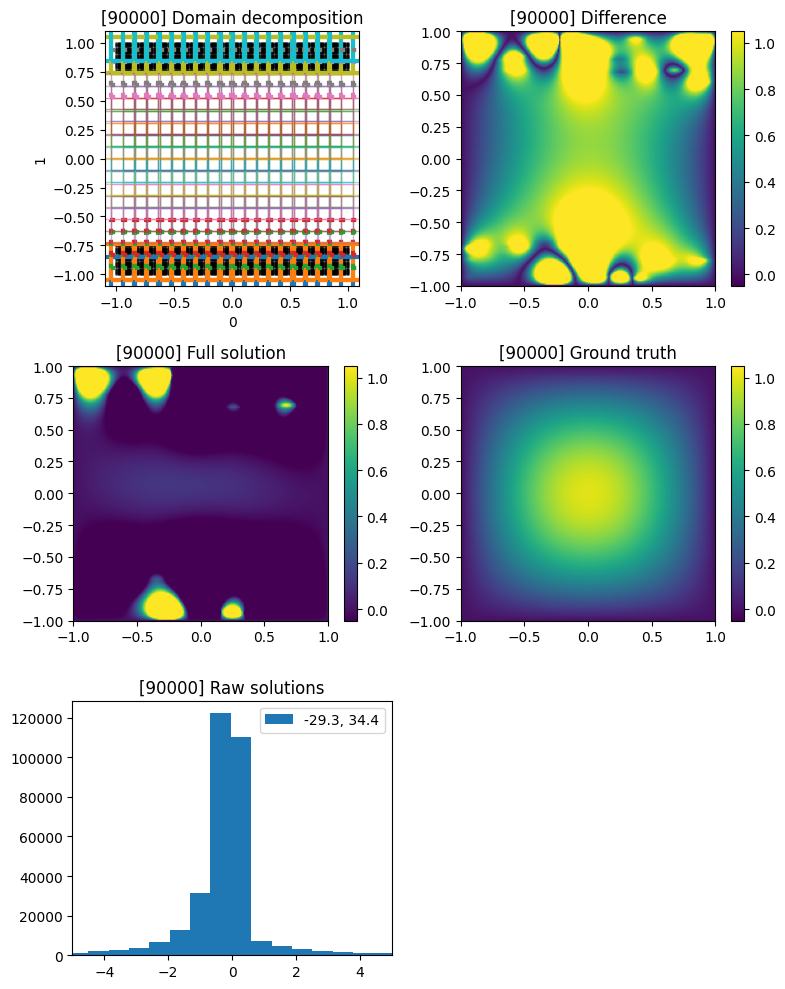

[INFO] 2025-03-26 19:49:51 - saved arrays
[INFO] 2025-03-26 19:49:51 - [i: 90000/100000] Updating active inputs..
[INFO] 2025-03-26 19:49:51 - [i: 90000/100000] Average number of points/dimension in active subdomains: 21.35
[INFO] 2025-03-26 19:49:53 - [i: 90000/100000] Updating active inputs done (1.94 s)
[INFO] 2025-03-26 19:49:53 - [i: 90000/100000] Compiling update step..
[INFO] 2025-03-26 19:49:53 - x_batch
[INFO] 2025-03-26 19:49:53 - (6400, 2), float32, JVPTracer
[INFO] 2025-03-26 19:49:53 - x_take
[INFO] 2025-03-26 19:49:53 - (47880, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:49:53 - x_batch
[INFO] 2025-03-26 19:49:53 - (6400, 2), float32, JVPTracer
[INFO] 2025-03-26 19:49:53 - x_take
[INFO] 2025-03-26 19:49:53 - (47880, 2), float32, JVPTracer
input: (2,)
(16,)
(16,)
(16,)
output: (1,)
[INFO] 2025-03-26 19:49:55 - [i: 90000/100000] Compiling done (1.85 s)
[INFO] 2025-03-26 19:49:55 - [i: 91000/100000] loss: 36.9829 rate: 220.4 elapsed

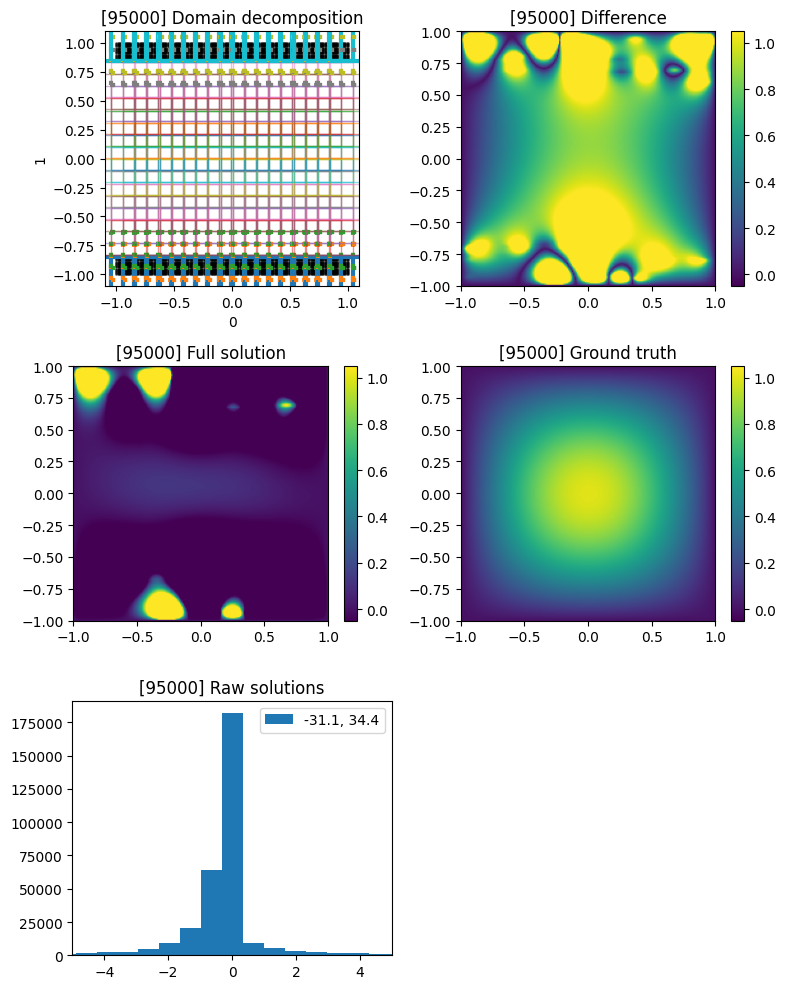

[INFO] 2025-03-26 19:49:59 - saved arrays
[INFO] 2025-03-26 19:50:00 - [i: 96000/100000] loss: 31.9009 rate: 1442.4 elapsed: 0.06 hr test
[INFO] 2025-03-26 19:50:01 - [i: 97000/100000] loss: 24.4503 rate: 1436.4 elapsed: 0.06 hr test
[INFO] 2025-03-26 19:50:02 - [i: 98000/100000] loss: 22.7089 rate: 1439.0 elapsed: 0.06 hr test
[INFO] 2025-03-26 19:50:02 - [i: 99000/100000] loss: 22.5885 rate: 1444.1 elapsed: 0.06 hr test
[INFO] 2025-03-26 19:50:03 - [i: 100000/100000] loss: 21.9766 rate: 1438.9 elapsed: 0.06 hr test
True


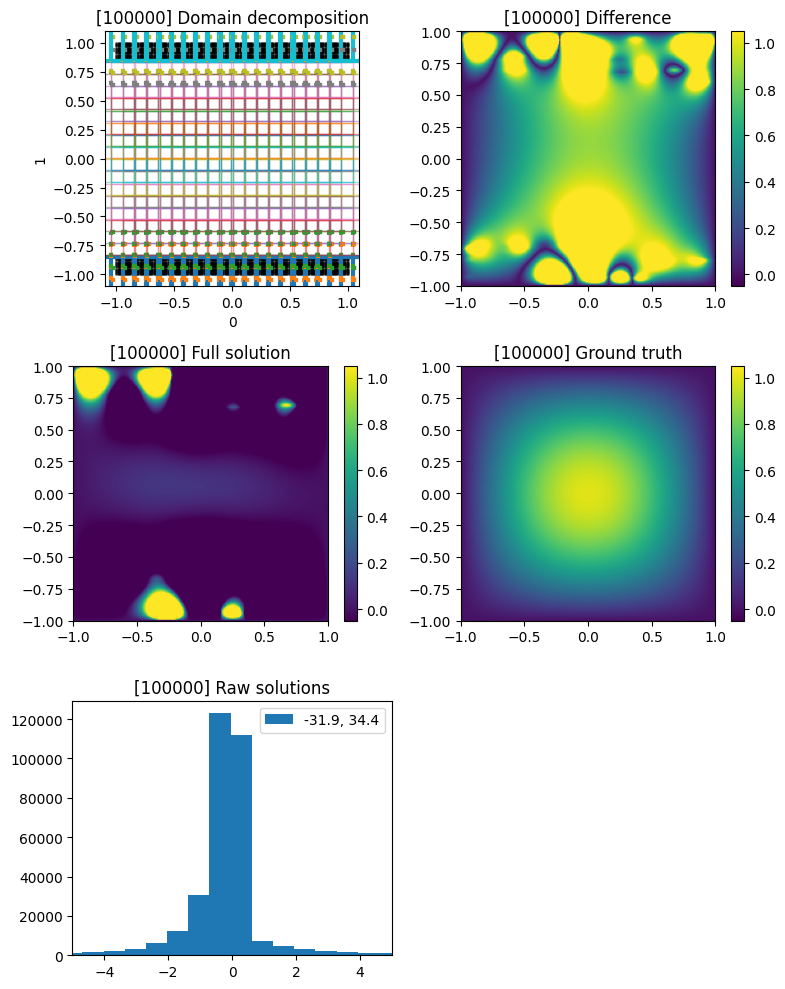

[INFO] 2025-03-26 19:50:04 - saved arrays
[INFO] 2025-03-26 19:50:04 - [i: 100000/100000] Training complete


In [ ]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import ChebyshevKAN, FCN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

subdomain_xs=[np.linspace(-1,1,10), np.linspace(-1,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([-1.,-1.]),
        xmax=np.array([1.,1.])
        ),
    problem=Poisson2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0., 1.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 16, 1),
    # ),
    network=ChebyshevKAN,
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=15
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    # First element: interior sampling shape for the physics loss (here 200 x 200 points)
    # Second element: boundary sampling shapes; for 2D, we need 4 tuples (one for each boundary)
    ns=((200, 200),),
    # n_test provides the test sampling shape for the interior (here also 200 x 200)
    n_test=(200, 200),
    n_steps=100000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()